In [1]:
!pip install japanize_matplotlib

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [2]:
from tensorflow.keras.utils import get_file

url = 'https://github.com/odashi/small_parallel_enja/archive/master.zip'

zip_file_path = get_file('small_parallel_enja.zip', url, cache_subdir='small_parallel_enja', extract=True) 

In [3]:
import os

data_dir = os.path.join(os.path.dirname(zip_file_path), 'small_parallel_enja-master')
!ls -l $data_dir

total 9076
-rw-r--r-- 1 tensorflow tensorflow    1946 Feb 11 10:10 README.md
-rw-r--r-- 1 tensorflow tensorflow   17054 Feb 11 10:10 dev.en
-rw-r--r-- 1 tensorflow tensorflow   27781 Feb 11 10:10 dev.ja
-rw-r--r-- 1 tensorflow tensorflow   17301 Feb 11 10:10 test.en
-rw-r--r-- 1 tensorflow tensorflow   27793 Feb 11 10:10 test.ja
-rw-r--r-- 1 tensorflow tensorflow 1701356 Feb 11 10:10 train.en
-rw-r--r-- 1 tensorflow tensorflow  339768 Feb 11 10:10 train.en.000
-rw-r--r-- 1 tensorflow tensorflow  340186 Feb 11 10:10 train.en.001
-rw-r--r-- 1 tensorflow tensorflow  341174 Feb 11 10:10 train.en.002
-rw-r--r-- 1 tensorflow tensorflow  339953 Feb 11 10:10 train.en.003
-rw-r--r-- 1 tensorflow tensorflow  340275 Feb 11 10:10 train.en.004
-rw-r--r-- 1 tensorflow tensorflow   30025 Feb 11 10:10 train.en.vocab.4k
-rw-r--r-- 1 tensorflow tensorflow   51162 Feb 11 10:10 train.en.vocab.all
-rw-r--r-- 1 tensorflow tensorflow 2784447 Feb 11 10:10 train.ja
-rw-r--r-- 1 tensorflow tensorflow  556444 Fe

In [4]:
import os
import unicodedata
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

TRAIN_SIZE_LIMIT = 30000
TEST_SIZE_LIMIT = 300

def load_data(path):
    texts = []
    for line in open(path, 'r'):
        texts.append(line.strip())
    return texts
  
def preprocess(text):
    text = unicodedata.normalize('NFKC', text)
    text = '<start> ' + text + ' <end>'
    return text

train_en = load_data(os.path.join(data_dir, 'train.en'))
train_ja = load_data(os.path.join(data_dir, 'train.ja'))

train_en = train_en[:TRAIN_SIZE_LIMIT]
train_ja = train_ja[:TRAIN_SIZE_LIMIT]

train_input = [preprocess(s) for s in train_en]
train_target = [preprocess(s) for s in train_ja]

In [5]:
en_vectorizer = TextVectorization(max_tokens=20000,
                                  standardize=None,
                                  output_mode='int',
                                  output_sequence_length=18)

en_vectorizer.adapt(train_input)

ja_vectorizer = TextVectorization(max_tokens=20000,
                                  standardize=None,
                                  output_mode='int',
                                  output_sequence_length=18)

ja_vectorizer.adapt(train_target)

In [6]:
train_input_ds = tf.data.Dataset.from_tensor_slices(en_vectorizer(train_input))
train_target_ds = tf.data.Dataset.from_tensor_slices(ja_vectorizer(train_target))

In [7]:
train_ds = tf.data.Dataset.zip((train_input_ds, train_target_ds))

In [8]:
en_vocab = en_vectorizer.get_vocabulary()
ja_vocab = ja_vectorizer.get_vocabulary()
vocab_inp_size = len(en_vocab) + 1
vocab_tar_size = len(ja_vocab) + 1

In [9]:
max_length_inp = 18
max_length_targ = 18

In [10]:
def convert(vocab, tensor):
    for t in tensor:
        if t!=0:
            print ("%d ----> %s" % (t, vocab[t]))

In [11]:
en, ja = next(iter(train_ds))

In [12]:
print ("Input Language; index to word mapping")
convert(en_vocab, en.numpy())
print ()
print ("Target Language; index to word mapping")
convert(ja_vocab, ja.numpy())

Input Language; index to word mapping
2 ----> <start>
6 ----> i
41 ----> can
22 ----> 't
149 ----> tell
136 ----> who
29 ----> will
709 ----> arrive
231 ----> first
4 ----> .
3 ----> <end>

Target Language; index to word mapping
2 ----> <start>
92 ----> 誰
14 ----> が
239 ----> 一番
7 ----> に
161 ----> 着
29 ----> く
22 ----> か
18 ----> 私
7 ----> に
5 ----> は
290 ----> 分か
39 ----> り
21 ----> ま
40 ----> せ
30 ----> ん
4 ----> 。
3 ----> <end>


In [13]:
BUFFER_SIZE = len(train_input)
BATCH_SIZE = 64
steps_per_epoch = len(train_input) // BATCH_SIZE
embedding_dim = 256
units = 1024

dataset = train_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [14]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 18]), TensorShape([64, 18]))

In [15]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.enc_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')

    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state = hidden)
        return output, state

    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))

In [16]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# サンプル入力
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 18, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


In [17]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, query, values):
        # hidden shape == (batch_size, hidden size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden size)
        # スコアを計算するためにこのように加算を実行する
        hidden_with_time_axis = tf.expand_dims(query, 1)

        # score shape == (batch_size, max_length, 1)
        # スコアを self.V に適用するために最後の軸は 1 となる
        # self.V に適用する前のテンソルの shape は  (batch_size, max_length, units)
        score = self.V(tf.nn.tanh(
                      self.W1(values) + self.W2(hidden_with_time_axis)))

        # attention_weights の shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector の合計後の shape == (batch_size, hidden_size)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [18]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 18, 1)


In [19]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.dec_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc = tf.keras.layers.Dense(vocab_size)

        # アテンションのため
        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, hidden, enc_output):
        # enc_output の shape == (batch_size, max_length, hidden_size)
        context_vector, attention_weights = self.attention(hidden, enc_output)

        # 埋め込み層を通過したあとの x の shape  == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

        # 結合後の x の shape == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # 結合したベクトルを GRU 層に渡す
        output, state = self.gru(x)

        # output shape == (batch_size * 1, hidden_size)
        output = tf.reshape(output, (-1, output.shape[2]))

        # output shape == (batch_size, vocab)
        x = self.fc(output)

        return x, state, attention_weights

In [20]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 6952)


In [21]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
                             from_logits=True, reduction='none')
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [22]:
import os

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [23]:
@tf.function
def train_step(inp, targ, enc_hidden):
    loss = 0

    with tf.GradientTape() as tape:
        enc_output, enc_hidden = encoder(inp, enc_hidden)

        dec_hidden = enc_hidden

        dec_input = tf.expand_dims([ja_vocab.index('<start>')] * BATCH_SIZE, 1)

        # Teacher Forcing - 正解値を次の入力として供給
        for t in range(1, targ.shape[1]):
            # passing enc_output to the decoder
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

            loss += loss_function(targ[:, t], predictions)

            # Teacher Forcing を使用
            dec_input = tf.expand_dims(targ[:, t], 1)

    batch_loss = (loss / int(targ.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, variables)

    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss

In [24]:
import time

EPOCHS = 20

for epoch in range(EPOCHS):
    start = time.time()

    enc_hidden = encoder.initialize_hidden_state()
    total_loss = 0

    for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
        batch_loss = train_step(inp, targ, enc_hidden)
        total_loss += batch_loss

        if batch % 100 == 0:
              print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                     batch,
                                                     batch_loss.numpy()))
    # 2 エポックごとにモデル（のチェックポイント）を保存
    if (epoch + 1) % 2 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)

    print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 6.1205
Epoch 1 Batch 100 Loss 2.6564
Epoch 1 Batch 200 Loss 2.3286
Epoch 1 Batch 300 Loss 2.2678
Epoch 1 Batch 400 Loss 2.2476
Epoch 1 Loss 2.5152
Time taken for 1 epoch 54.825743436813354 sec

Epoch 2 Batch 0 Loss 1.8989
Epoch 2 Batch 100 Loss 1.9250
Epoch 2 Batch 200 Loss 1.8727
Epoch 2 Batch 300 Loss 1.8464
Epoch 2 Batch 400 Loss 1.8113
Epoch 2 Loss 1.8795
Time taken for 1 epoch 36.00258159637451 sec

Epoch 3 Batch 0 Loss 1.5908
Epoch 3 Batch 100 Loss 1.7378
Epoch 3 Batch 200 Loss 1.7886
Epoch 3 Batch 300 Loss 1.6569
Epoch 3 Batch 400 Loss 1.5471
Epoch 3 Loss 1.6218
Time taken for 1 epoch 35.02392625808716 sec

Epoch 4 Batch 0 Loss 1.3151
Epoch 4 Batch 100 Loss 1.3490
Epoch 4 Batch 200 Loss 1.3743
Epoch 4 Batch 300 Loss 1.2452
Epoch 4 Batch 400 Loss 1.2473
Epoch 4 Loss 1.3584
Time taken for 1 epoch 35.90100336074829 sec

Epoch 5 Batch 0 Loss 1.0758
Epoch 5 Batch 100 Loss 1.1607
Epoch 5 Batch 200 Loss 1.1555
Epoch 5 Batch 300 Loss 0.9708
Epoch 5 Batch 400 Loss 1.

In [25]:
import numpy as np

en_word_index = {w:i for i,w in enumerate(en_vocab)}

def evaluate(sentence):
    sentence = preprocess(sentence)
    
    attention_plot = np.zeros((max_length_targ, max_length_inp))

    inputs = [en_word_index.get(w, 1) for w in sentence.split(' ')] # index 1 for [UNK]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                           maxlen=max_length_inp,
                                                           padding='post')
    inputs = tf.convert_to_tensor(inputs)

    result = ''

    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([ja_vocab.index('<start>')], 0)

    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        # 後ほどプロットするためにアテンションの重みを保存
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()

        if ja_vocab[predicted_id] == '<end>':
            return result, sentence, attention_plot

        result += ja_vocab[predicted_id] + ' '

        # 予測された ID がモデルに戻される
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot

In [26]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import japanize_matplotlib

# アテンションの重みをプロットする関数
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [27]:
def translate(sentence):
    result, sentence, attention_plot = evaluate(sentence)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [28]:
# checkpoint_dir の中の最後のチェックポイントを復元
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Input: <start> i am a little out of sorts today . <end>
Predicted translation: 今日 は 少し 気分 が 悪 い 。 


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  


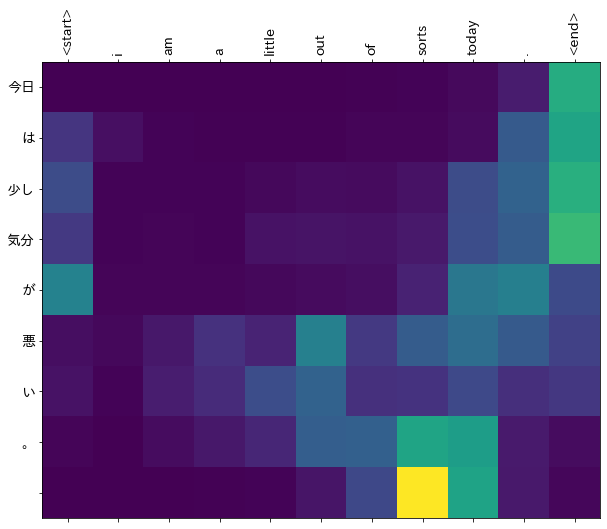

In [29]:
translate("i am a little out of sorts today .")

In [30]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import pandas as pd

input_sentences = load_data(os.path.join(data_dir, 'test.en'))
target_sentences = load_data(os.path.join(data_dir, 'test.ja'))

input_sentences = input_sentences[:TEST_SIZE_LIMIT]
target_sentences = target_sentences[:TEST_SIZE_LIMIT]
predicted_sentences = []

for input_en in input_sentences:
    predicted_ja, _, _ = evaluate(preprocess(input_en))
    predicted_sentences.append(''.join(predicted_ja[:-1]))

result_df = pd.DataFrame({'input_sentence': input_sentences,
                          'target_sentence': target_sentences,
                          'predicted_sentence': predicted_sentences})  


In [31]:
bleu_scores = []
for row in result_df.itertuples():
    bleu_scores.append(
        sentence_bleu(row.target_sentence, row.predicted_sentence,
                      smoothing_function=SmoothingFunction().method4)
    )
result_df['bleu_score'] = bleu_scores

In [32]:
result_df

,input_sentence,target_sentence,predicted_sentence,bleu_score
0,they finally acknowledged it as true .,彼 ら は つい に それ が 真実 だ と 認め た 。,彼 ら は それ を 言 っ た 。,0.269130
1,he didn 't care for swimming .,彼 は 水泳 が 得意 で は な かっ た 。,彼 は 泳ぎ を 入れ な かっ た 。,0.243904
2,he is no less kind than his sister .,彼 は お 姉 さん に 劣 ら ず 親切 だ 。,彼 は お 姉 さん と 話 す こと は 容易 で は な い 。,0.127277
3,you must be back before ten .,１０ 時 前 に 戻 ら な けれ ば な ら な い 。,10 時 まで に 戻 る な 。,0.268659
4,break a leg .,成功 を 祈 る わ 。,い い な さ い 。,0.356676
...,...,...,...,...
295,i 'm very sleepy now .,今 とても 眠 い 。,とても 疲れ で す 。,0.399584
296,"above the music , i could hear her crying .",音楽 が な っ て い る の に 彼女 の 鳴き声 が 聞こえ た 。,その 先生 の 話 を 知 ら せ ん だ と 思 っ た の で い る,0.107584
297,we had the meeting in this room last friday .,先週 の 金曜 日 この 部屋 で 会合 が あ っ た 。,この 部屋 の 部屋 が あ り ま し た 。,0.196274
298,who do you want to speak to ?,お 話 に な る 方 の お 名前 は 。,誰 が ため に 話 し た い で す か 。,0.160257


In [33]:
result_df.bleu_score.mean()

0.1926190246410859